In [1]:
#Import some basic data science python modules, the only non-usual module is SARIMAX for our modeling
import warnings
import pandas as pd
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from datetime import datetime, date
import seaborn as sns
import numpy as np
from statsmodels.tsa.api import SARIMAX

warnings.filterwarnings("ignore")

In [2]:
#Importing the data that we got from GEE and format it properly
burndata = pd.read_csv('fixedburndata.csv')
burndata.rename(columns={burndata.columns[0]:'date'},inplace=True)
burndata.date=pd.to_datetime(burndata.date,format='%Y_%m_%d')
burndata=burndata.set_index('date')


In [3]:
burndata.head()

,lon,lat,burn_area,area
date,,,,
2015-01-01,14.496897,-5.130336,0.0,0
2015-02-01,14.496897,-5.130336,0.0,0
2015-03-01,14.496897,-5.130336,0.0,0
2015-04-01,14.496897,-5.130336,0.0,0
2015-05-01,14.496897,-5.130336,0.0,0


In [4]:
#Just a simple function that sorts by area
def sort_location(location):
    df =burndata.loc[(burndata.area==location)].sort_index()
    return df

In [5]:
#we have 20 areas, so it sorts by area
loc= list(np.arange(20))

In [6]:
loc

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

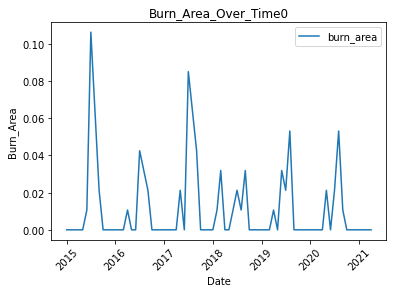

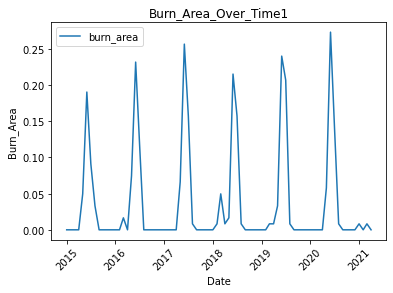

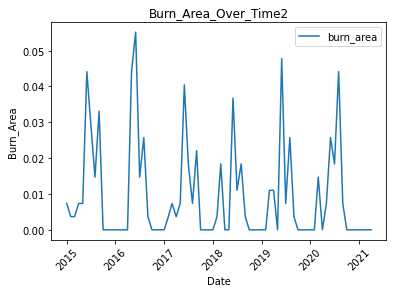

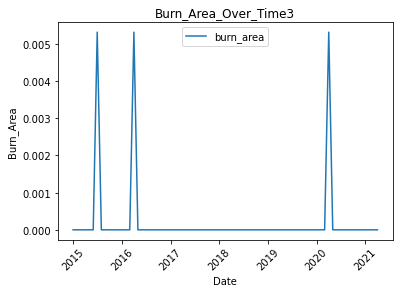

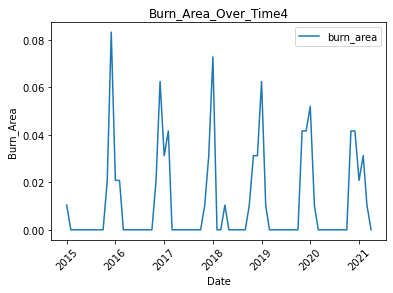

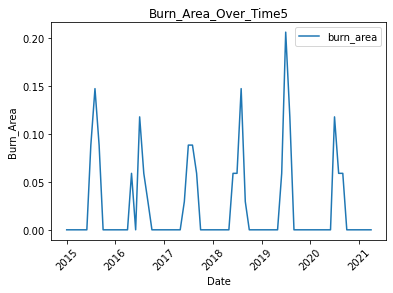

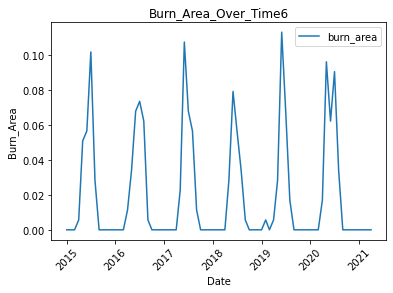

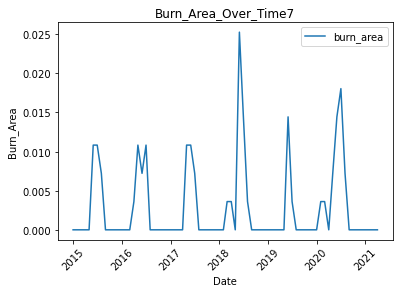

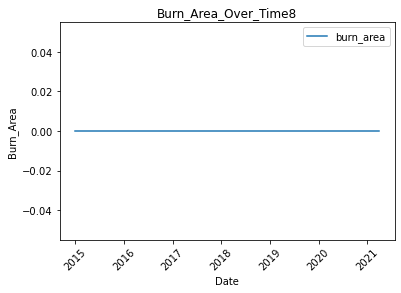

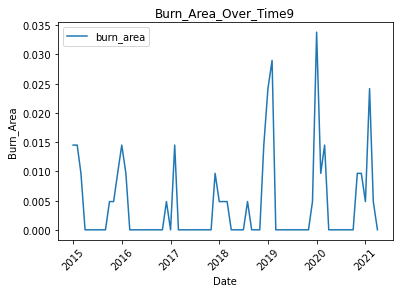

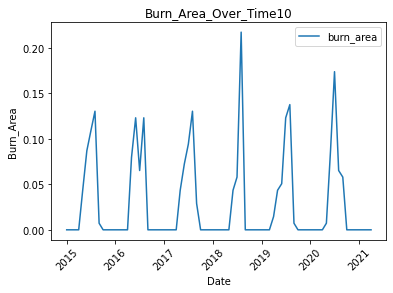

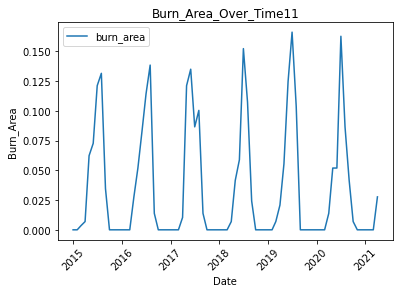

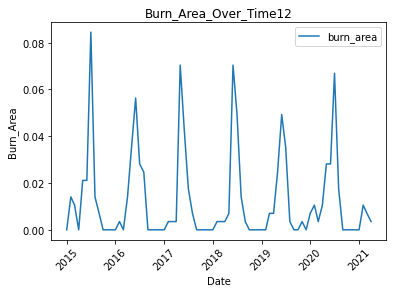

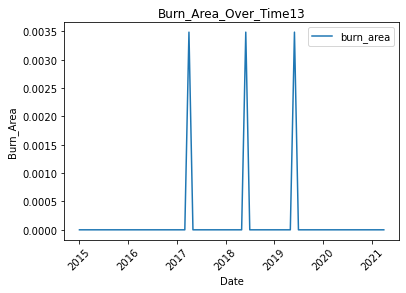

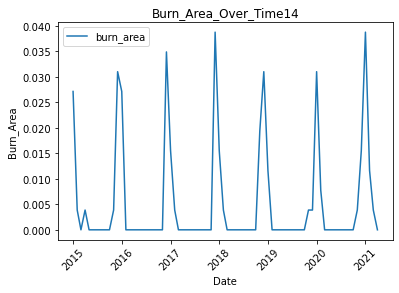

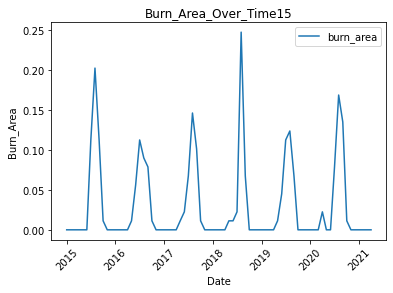

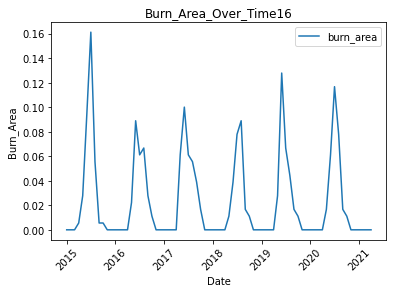

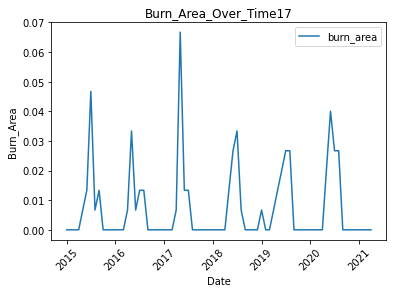

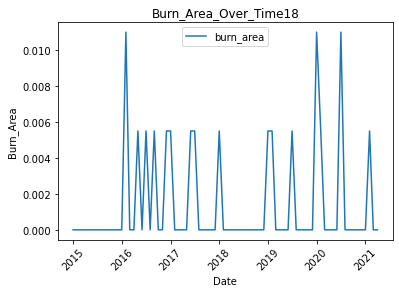

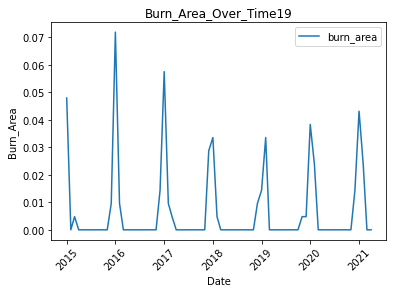

In [7]:
# Look at our data over time
for location in loc:
    df=sort_location(location)
    plt.plot(df.index, 'burn_area',data=df)
    plt.xticks(rotation = 45)
    plt.xlabel('Date')
    plt.ylabel('Burn_Area')
    plt.title('Burn_Area_Over_Time'+str(location))
    plt.legend()
    plt.show()


In [ ]:
# We can see that our data has yearly seasonality depending on the wet/dry season, so we can use a SARIMA model (the S stands for seasonal)


# Testing models

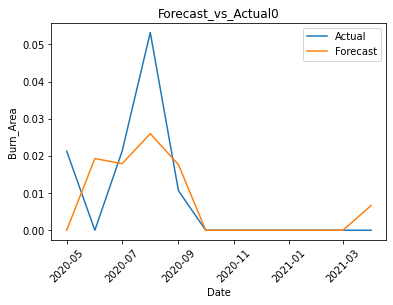

RMSE: 0.011797345972019396


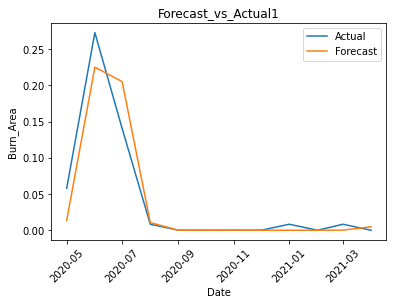

RMSE: 0.026728716575497483


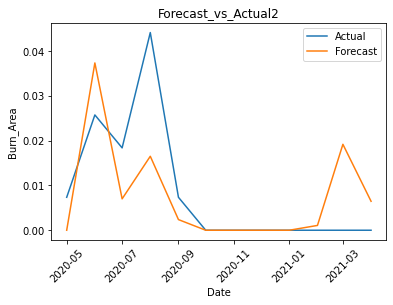

RMSE: 0.011239316781856004


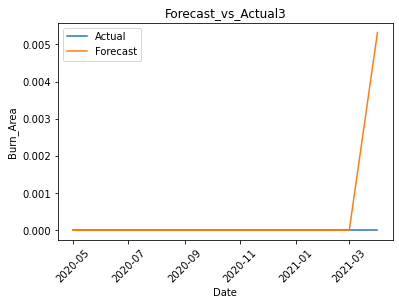

RMSE: 0.00153550454149396


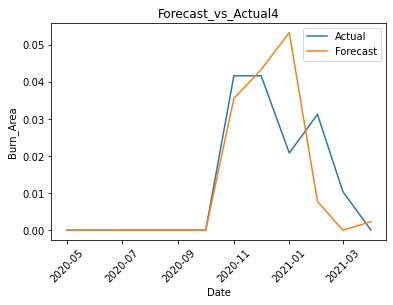

RMSE: 0.01211307557806454


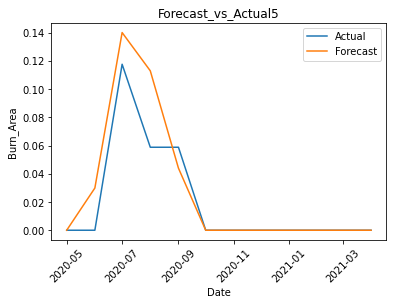

RMSE: 0.019478482743599708


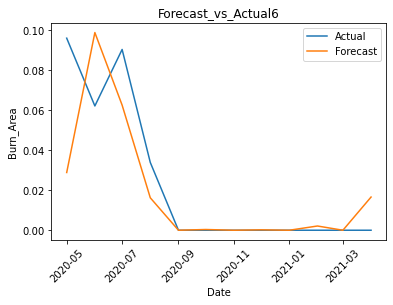

RMSE: 0.024540704247588103


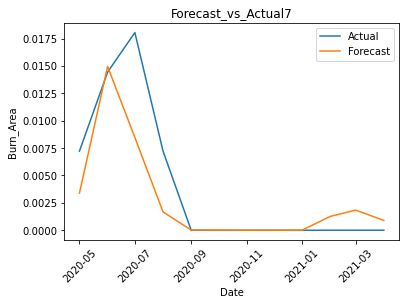

RMSE: 0.003456271009393384


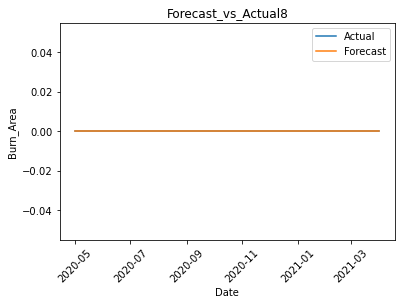

RMSE: 0.0


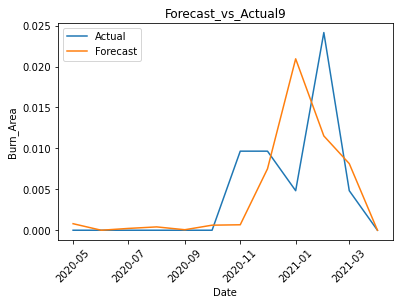

RMSE: 0.006563660173930517


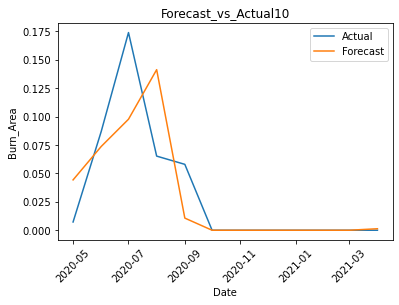

RMSE: 0.035804783458189514


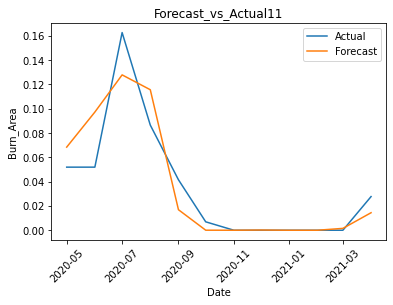

RMSE: 0.02084957091783899


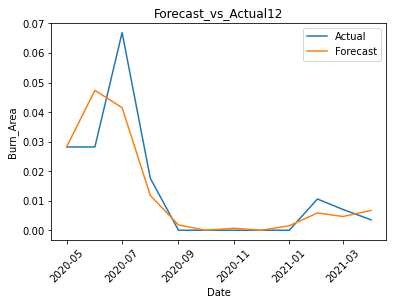

RMSE: 0.009535927711066412


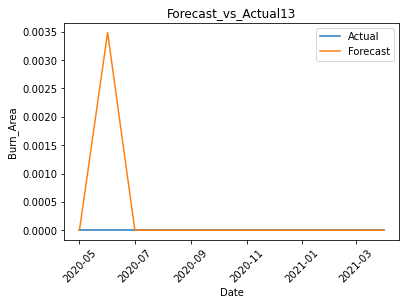

RMSE: 0.0010058368336411032


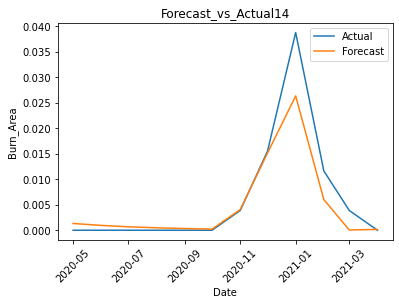

RMSE: 0.004125246879991066


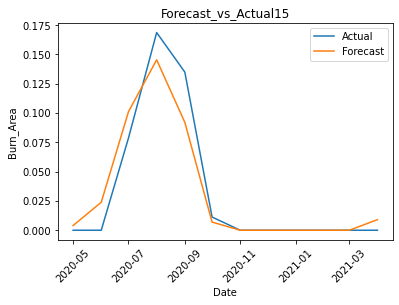

RMSE: 0.01723959962452666


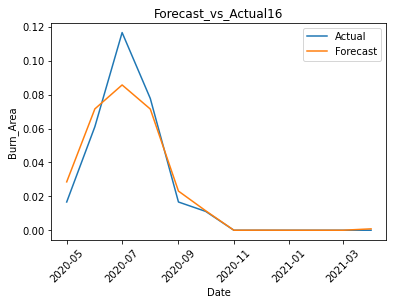

RMSE: 0.010361198492217063


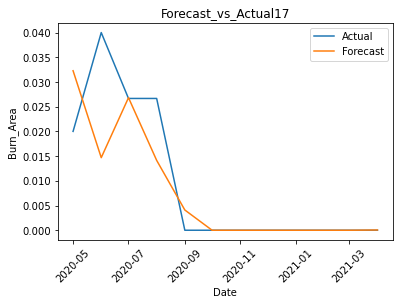

RMSE: 0.008968513675316706


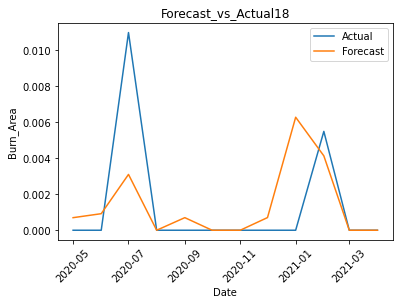

RMSE: 0.0029695252484571466


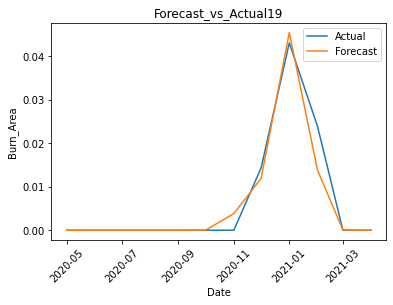

RMSE: 0.0032658226683007605


In [37]:
#Create a train/test split for each of the 20 models and allows us to analyze the forecasting
# The parameters were chosen by playing around with the models (Could be done in a more technical way by grid search or looking at PCF and ACF)
for location in loc:
    df=sort_location(location)
    df_train=df.iloc[:-12]
    df_test = df.iloc[-12:]
    model=SARIMAX(df_train.burn_area,order=(1, 0, 1),seasonal_order=(1,1,2,12))
    model_fitted= model.fit()
    yhat = model_fitted.forecast(12)
    forecast = pd.DataFrame(yhat).rename(columns={'predicted_mean':'burn_area_forecast'})
    forecast['date']=df_test.index
    forecast=forecast.set_index('date')
    forecast.loc[forecast.burn_area_forecast <0]=0
    plt.plot(df_test.index, 'burn_area',data=df_test,label='Actual')
    plt.plot(forecast.index, 'burn_area_forecast',data=forecast,label='Forecast')
    plt.xticks(rotation = 45)
    plt.xlabel('Date')
    plt.ylabel('Burn_Area')
    plt.title('Forecast_vs_Actual'+str(location))
    plt.legend()
    plt.show()
    print('RMSE:',np.sqrt(mean_squared_error(forecast.burn_area_forecast,df_test.burn_area)))

# Forecasting

In [26]:
#This creates a dataframe of the 5 years into the future for each of the models
forecast_df=pd.DataFrame(columns=['burn_area_forecast','lon','lat','area'])
for location in loc:
    df=sort_location(location)
    model=SARIMAX(df.burn_area,order=(1, 0, 1),seasonal_order=(1,1,2,12))
    model_fitted= model.fit()
    yhat = model_fitted.forecast(60)
    forecast = pd.DataFrame(yhat).rename(columns={'predicted_mean':'burn_area_forecast'})
    forecast['date']=(pd.period_range(start='2021-05-01', end='2026-04-01', freq='M')).to_timestamp()
    forecast=forecast.set_index('date')
    forecast.loc[forecast.burn_area_forecast <0]=0
    forecast['lon']=df.lon.iloc[0]
    forecast['lat']=df.lat.iloc[0]
    forecast['area']=df.area.iloc[0]
    forecast_df=pd.concat([forecast_df,forecast])

In [27]:
forecast_df.head()

,burn_area_forecast,lon,lat,area
2021-05-01,0.006729,14.496897,-5.130336,0
2021-06-01,0.019419,14.496897,-5.130336,0
2021-07-01,0.018345,14.496897,-5.130336,0
2021-08-01,0.047614,14.496897,-5.130336,0
2021-09-01,0.006136,14.496897,-5.130336,0


In [28]:
#Doing this because of the way that it reads it to CSV it is easier to have our dates in a column rather than index
forecast_df['date']=forecast_df.index

In [29]:
forecast_df.to_csv('FixedForecastData.csv', index=False)